In [3]:
pip install opencv-python

  Using cached opencv_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl (35.4 MB)

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report

import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism



KeyboardInterrupt: 

In [ ]:
train_dir='../Dataset/tom-jerry-detection/train/train'
test_dir='../Dataset/tom-jerry-detection/test'

In [ ]:
class_names0 = os.listdir(train_dir)
class_names = sorted(class_names0)
print(class_names)

num_class = len(class_names)
image_files = [[os.path.join(train_dir, class_name, x) 
               for x in os.listdir(os.path.join(train_dir, class_name))] 
               for class_name in class_names]

image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

['angry', 'happy', 'sad', 'surprised', 'unknown']


In [ ]:
valid_frac = 0.25
trainX,trainY = [],[]
valX,valY = [],[]

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print(len(trainX),len(valX))

231 67


In [ ]:
t_class_names0 = os.listdir(test_dir)
t_class_names = sorted(t_class_names0)
print(t_class_names)
t_num_class = len(t_class_names)
t_image_files = [[os.path.join(test_dir, t_class_name, x) 
               for x in os.listdir(os.path.join(test_dir, t_class_name))] 
               for t_class_name in t_class_names]

t_image_file_list = []
t_image_label_list = []
for i, class_name in enumerate(t_class_names):
    t_image_file_list.extend(t_image_files[i])
    t_image_label_list.extend([i] * len(t_image_files[i]))
      

['test_extract']


(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


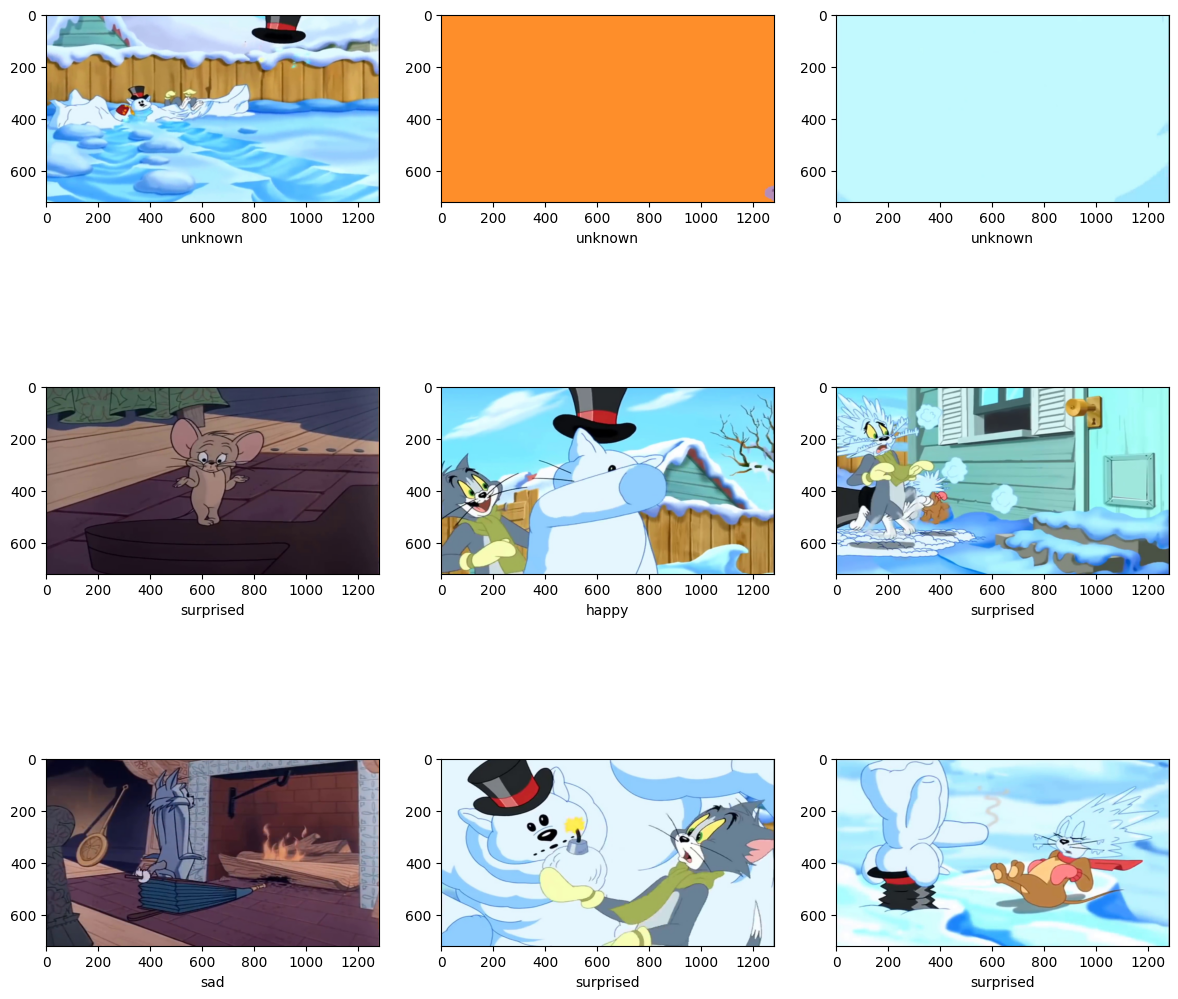

In [ ]:
plt.subplots(3,3, figsize=(12,12))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    print(arr.shape)
    plt.subplot(3,3, i+1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [ ]:
trainX=np.array(trainX)
trainY=np.array(trainY)
valX=np.array(valX)
valY=np.array(valY)
testX=np.array(t_image_file_list)
testY=np.array(t_image_label_list)

In [ ]:
class SumDimension(Transform):
    def __init__(self, dim=1):
        self.dim = dim

    def __call__(self, inputs):
        return inputs.sum(self.dim)

In [ ]:
class MyResize(Transform):
    def __init__(self, size=(60,80)):
        self.size = size
    def __call__(self, inputs):
        image2=cv2.resize(inputs,dsize=(self.size[1],self.size[0]),interpolation=cv2.INTER_CUBIC)
        return image2

In [ ]:
train_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    SumDimension(2),
    MyResize(),  
    ToTensor(),
])

val_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    SumDimension(2),
    MyResize(),   
    ToTensor(),
])

test_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    SumDimension(2),
    MyResize(),   
    ToTensor(),
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=num_class, n_classes=num_class)

In [ ]:
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [ ]:
train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, num_workers=2)

test_ds = MedNISTDataset(testX, testY, test_transforms)
test_loader = DataLoader(test_ds, batch_size=64, num_workers=2)


In [ ]:
device = torch.device("cpu")   #"cuda:0"
model = DenseNet121(
    spatial_dims=2,            
    in_channels=1,
    out_channels=num_class,
).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 30
val_interval = 1

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()

for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())     ##### 
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images.float())], dim=0)
                y = torch.cat([y, val_labels], dim=0)
                
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
                
            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
            
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/30


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.11/3.11.7/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.11/3.11.7/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
    exitcode = _main(fd, parent_sentinel)
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/opt/homebrew/Cellar/python@3.11/3.11.7/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
  File "/opt/homebrew/Cellar/python@3.11/3.11.7/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
    self = reduction.pic

RuntimeError: DataLoader worker (pid(s) 6600, 6601) exited unexpectedly

In [ ]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()

with torch.no_grad():
    for val_data in val_loader:
        val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
        pred = model(val_images.float()).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(val_labels[i].item())
            y_pred.append(pred[i].item())

FileNotFoundError: [Errno 2] No such file or directory: 'best_metric_model.pth'